# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 3</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [24]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp


In [25]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 3. Clasificacion

### a. Construcción del target

La idea de este Trabajo es poder predecir el precio de una propiedad.  
El tipo de precio puede ser alto, medio o bajo, y para evaluar el mismo vamos a generarnos una nueva variable en el dataset, que sea el precio por metro cuadrado

In [26]:

viviendas_caba_train.drop(columns=['Unnamed: 0'],inplace=True)


In [27]:
viviendas_caba_train['pxm2'] = viviendas_caba_train.property_price / viviendas_caba_train.property_surface_total
viviendas_caba_train.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2
0,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.0,65.000000,53.0,198000.0,1 - Holmberg 2700,POINT (-58.4796377 -34.566536),3046.153846
1,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,POINT (-58.4594077 -34.6456246),2172.413793
2,2021-11-16,2021-11-18,-34.616825,-58.443603,Caballito,Departamento,2.0,1.0,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,POINT (-58.44360306 -34.61682542),2268.292683
3,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,Departamento,1.0,1.0,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,POINT (-58.4233675 -34.5770327),3265.306122
4,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,Departamento,1.0,2.0,91.044775,78.0,290000.0,Departamento en Palermo,POINT (-58.412815 -34.58021),3185.245942


Para evaluar el tipo de precio, procedemos a subclasificar el precio por metro cuadrado segun las cantidades de observaciones.  
Primero lo hacemos con cantidad igual de observaciones y luego dividimos en cuartiles , el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.  
Finalmente selecionaremos cada tipo de propiedad y haremos las mismas divisiones mencionadas.

In [28]:
labels=["Bajo","Medio","Alto"]

viviendas_caba_train["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train["pxm2"],q=3, labels=labels)
viviendas_caba_train["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train["pxm2"],q=[0,0.25,0.75,1], labels=labels)
viviendas_agrupada_tipo_precio_igual_frec = viviendas_caba_train.groupby(["tipo_precio_igual_frec"]).count()
viviendas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_depto = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Departamento"]
viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
deptos_agrupado_tipo_precio_igual_frec = viviendas_caba_train_depto.groupby(["tipo_precio_igual_frec"]).count()
deptos_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_depto.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_ph = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"]
viviendas_caba_train_ph["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=3, labels=labels)
viviendas_caba_train_ph["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_ph["pxm2"],q=[0,0.25,0.75,1], labels=labels)
ph_agrupado_tipo_precio_igual_frec = viviendas_caba_train_ph.groupby(["tipo_precio_igual_frec"]).count()
ph_agrupado_tipo_precio_25_50_25 = viviendas_caba_train_ph.groupby(["tipo_precio_25_50_25"]).count()

viviendas_caba_train_casa = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"]
viviendas_caba_train_casa["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=3, labels=labels)
viviendas_caba_train_casa["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_casa["pxm2"],q=[0,0.25,0.75,1], labels=labels)
casas_agrupada_tipo_precio_igual_frec = viviendas_caba_train_casa.groupby(["tipo_precio_igual_frec"]).count()
casas_agrupada_tipo_precio_25_50_25 = viviendas_caba_train_casa.groupby(["tipo_precio_25_50_25"]).count()


C:\Users\iankl\AppData\Local\Temp\ipykernel_6904\3705598243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_igual_frec"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels)
C:\Users\iankl\AppData\Local\Temp\ipykernel_6904\3705598243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viviendas_caba_train_depto["tipo_precio_25_50_25"] = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels)
C:\Users\iankl\AppData\Local\Temp\ipyke

Y ahora graficamos segun los intervalos obtenidos

[Text(0.5, 1.0, 'Intervalos de viviendas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

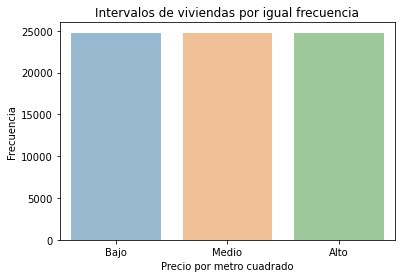

In [29]:
eje_x = viviendas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de viviendas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de viviendas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

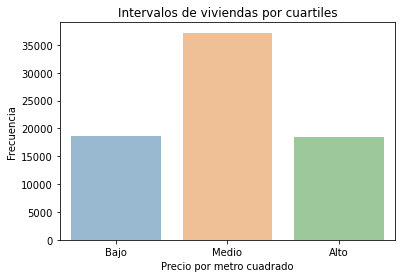

In [30]:
eje_x = viviendas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de viviendas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

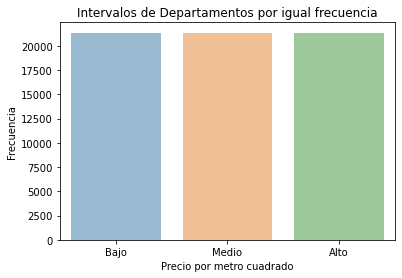

In [31]:
eje_x = deptos_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = deptos_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Departamentos por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

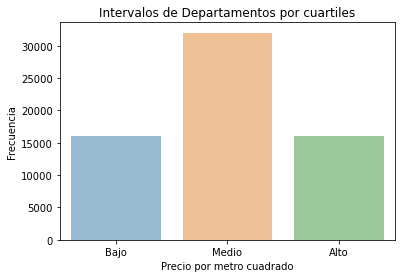

In [32]:
eje_x = deptos_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = deptos_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Departamentos por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de PH por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

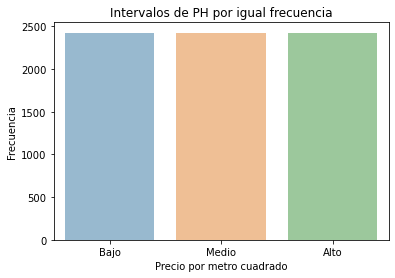

In [33]:
eje_x = ph_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = ph_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de PH por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')


[Text(0.5, 1.0, 'Intervalos de PH por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

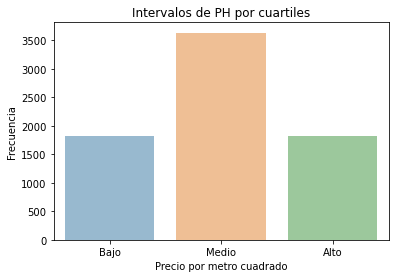

In [34]:
eje_x = ph_agrupado_tipo_precio_25_50_25.index.tolist()
eje_y = ph_agrupado_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de PH por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Casas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

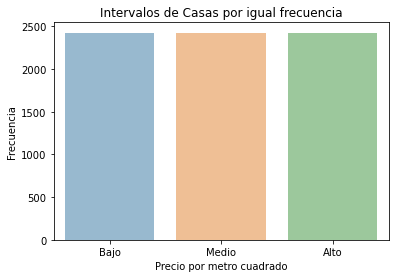

In [35]:
eje_x = casas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = casas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Casas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')



[Text(0.5, 1.0, 'Intervalos de Casas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

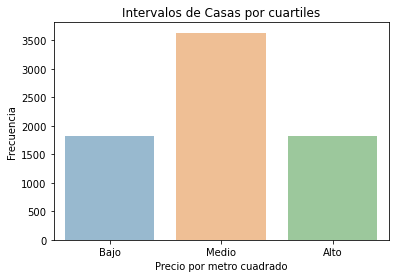

In [36]:
eje_x = casas_agrupada_tipo_precio_25_50_25.index.tolist()
eje_y = casas_agrupada_tipo_precio_25_50_25['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_25_50_25 ,alpha=0.5).set(title="Intervalos de Casas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

Para darnos una idea del target, vamos a mostrar la distribución del precio de las viviendas de todo el dataset


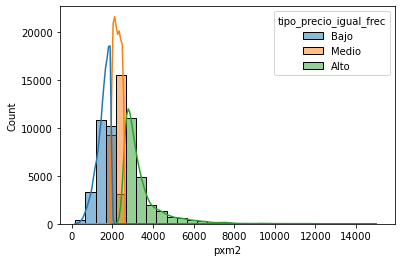

In [37]:
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_igual_frec', binwidth=500, kde=True)
plt.show()

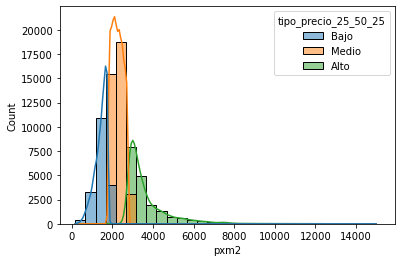

In [38]:
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_25_50_25', binwidth=500, kde=True)
plt.show()

Ahora vamos a hacer lo mismo para cada tipo de propiedad

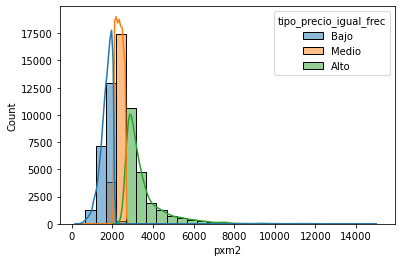

In [39]:
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_igual_frec', binwidth=500, kde=True)
plt.show()

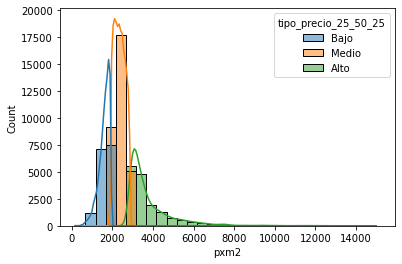

In [40]:
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_25_50_25', binwidth=500, kde=True)
plt.show()

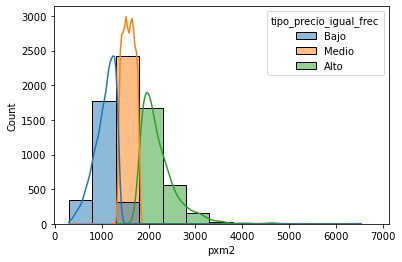

In [41]:
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_igual_frec', binwidth=500, kde=True)
plt.show()

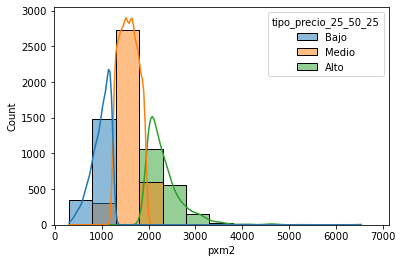

In [42]:
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_25_50_25', binwidth=500, kde=True)
plt.show()

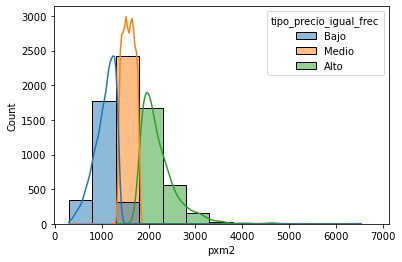

In [43]:
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_igual_frec', binwidth=500, kde=True)
plt.show()

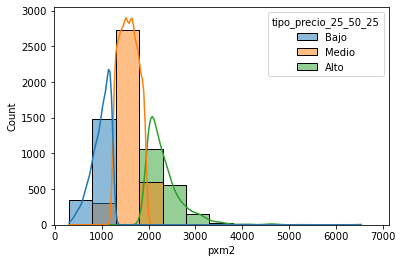

In [44]:
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_25_50_25', binwidth=500, kde=True)
plt.show()

De los graficos anteriores podemos concluir:
+ Hay muchos mas Departamentos que Casas o PHs, por lo cual vamos a predecir teniendo en cuenta el tipo de propiedad
+ Por los precios vistos, si dividimos por cuartiles la tendencia a predecir departamentos va a ser fuertemente de tipo 'medio', por la cantidad y por los precios que se pueden ver en los graficos, por lo cual elegimos utilizar el binning de misma frecuencia

In [45]:
viviendas_caba_train.loc[viviendas_caba_train_depto.index,"tipo_precio"] = viviendas_caba_train_depto["tipo_precio_igual_frec"] 
viviendas_caba_train.loc[viviendas_caba_train_ph.index,"tipo_precio"] = viviendas_caba_train_ph["tipo_precio_igual_frec"] 
viviendas_caba_train.loc[viviendas_caba_train_casa.index,"tipo_precio"] = viviendas_caba_train_casa["tipo_precio_igual_frec"] 

viviendas_caba_train.drop(columns=['tipo_precio_igual_frec', 'tipo_precio_25_50_25'], axis = 0, inplace=True)

viviendas_caba_train.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2,tipo_precio
0,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.0,65.000000,53.0,198000.0,1 - Holmberg 2700,POINT (-58.4796377 -34.566536),3046.153846,Alto
1,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,POINT (-58.4594077 -34.6456246),2172.413793,Medio
2,2021-11-16,2021-11-18,-34.616825,-58.443603,Caballito,Departamento,2.0,1.0,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,POINT (-58.44360306 -34.61682542),2268.292683,Medio
3,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,Departamento,1.0,1.0,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,POINT (-58.4233675 -34.5770327),3265.306122,Alto
4,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,Departamento,1.0,2.0,91.044775,78.0,290000.0,Departamento en Palermo,POINT (-58.412815 -34.58021),3185.245942,Alto


Ahora vamos a ver como se distribuyen las propiedades segun su tipo de precio en CABA

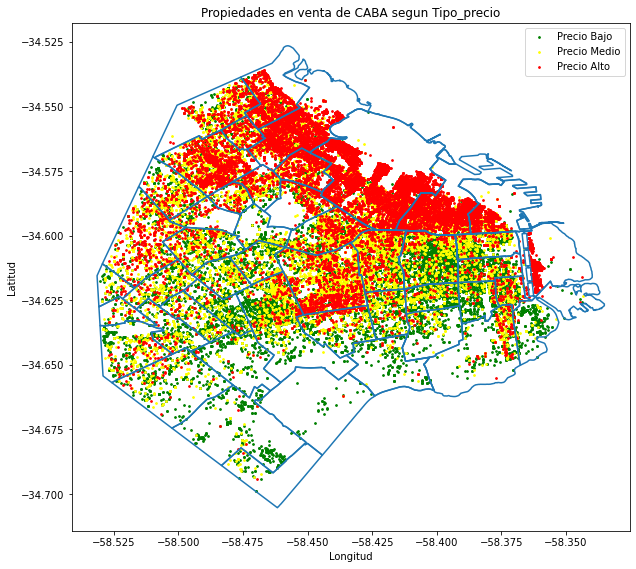

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Propiedades en venta de CABA segun Tipo_precio')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poly.boundary.plot(ax=ax) #CABA
viviendas_caba_train_bajo = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Bajo']
viviendas_caba_train_medio = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Medio']
viviendas_caba_train_alto = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Alto']
puntos_precio_bajo = gp.GeoDataFrame(viviendas_caba_train_bajo, geometry=gp.points_from_xy(viviendas_caba_train_bajo.longitud,viviendas_caba_train_bajo.latitud)) 
puntos_precio_medio = gp.GeoDataFrame(viviendas_caba_train_medio, geometry=gp.points_from_xy(viviendas_caba_train_medio.longitud,viviendas_caba_train_medio.latitud)) 
puntos_precio_alto = gp.GeoDataFrame(viviendas_caba_train_alto, geometry=gp.points_from_xy(viviendas_caba_train_alto.longitud,viviendas_caba_train_alto.latitud)) 
puntos_precio_bajo.plot(ax=ax,markersize=3, label = 'Precio Bajo', color="green")
puntos_precio_medio.plot(ax=ax,markersize=3, label = 'Precio Medio', color="yellow")
puntos_precio_alto.plot(ax=ax,markersize=3,label = 'Precio Alto', color="red")
plt.legend()

Se puede observar que en los barrios pertenecientes a la zona norte tienen mucha mas densidad de propiedades, lo cual tiene sentido dado que constantemente se esta construyendo en esos lugares.  
A su vez, en la zona meridional y sur hay menos propiedades en venta pero a mejor precio.
Puerto Madero esta lleno de chetos pero parece que hay propiedades en la reserva ecologica